In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from torch.utils.data import Dataset, DataLoader
import time
import sys
import pandas as pd
import tensorflow as tf

In [2]:

# Device
CUDA_DEVICE_NUM = 1
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda:1


In [3]:
train_dataset2=np.genfromtxt('../input/mnist-in-csv/mnist_train.csv',delimiter=',')
train_dataset2=train_dataset2[1:500,1:]
train_dataset2=np.where(train_dataset2>0.5,1,train_dataset2)
train_dataset2=np.where(train_dataset2<0.5,0,train_dataset2)
train_dataset2=torch.from_numpy(train_dataset2)



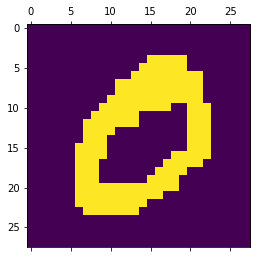

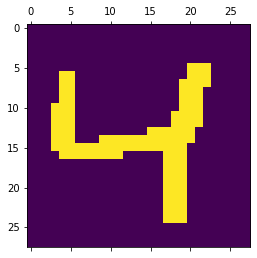

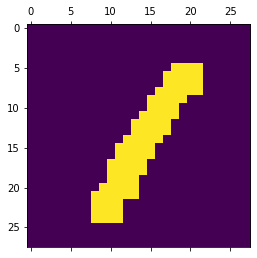

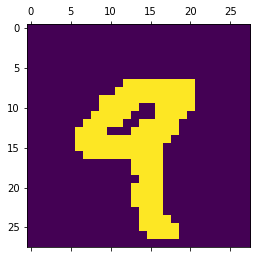

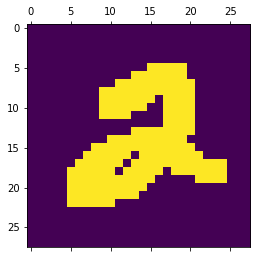

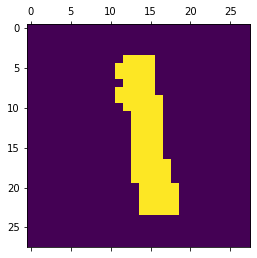

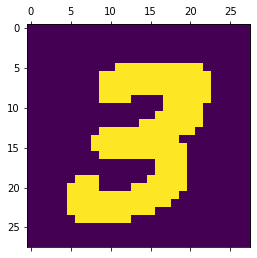

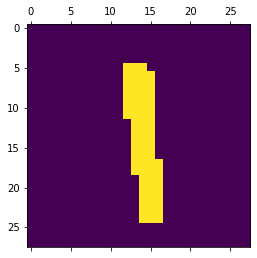

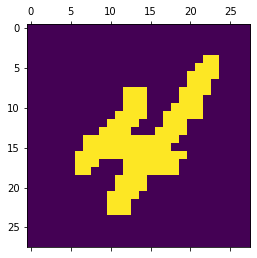

In [4]:
for i in train_dataset2[1:10]:
    plt.matshow(np.reshape(i,(28,28)))

In [15]:
torch.tensor([1-(1e-4)])

tensor([0.9999])

In [5]:
##FOR IMPLEMENTING STRAIGHT THROUGH BVAE

class binarization(torch.autograd.Function):
    
    @staticmethod
    def forward(self,input):
        a=input.clone()
        a[a>0.5]=torch.tensor([1-(1e-5)])
        a[a<0.5]=torch.tensor([0+1e-5])
        return a

        
    @staticmethod
    def backward(self,grad_output):
        grad_input = grad_output.clone()
        return grad_input
        
        
        

In [6]:
class bVAE(nn.Module):
  def __init__(self,latent_dim):
    super(bVAE, self).__init__()
    
    self.encoder=nn.Sequential(
        nn.Linear(input_size,512),
        nn.LeakyReLU(0.1),

        nn.Linear(512,256),
        nn.LeakyReLU(0.1),

        nn.Linear(256,latent_dim),
        nn.Sigmoid(),
    )

    self.decoder=nn.Sequential(
        nn.Linear(latent_dim,256),
        nn.LeakyReLU(0.1),

        nn.Linear(256,512),
        nn.LeakyReLU(0.1),

        nn.Linear(512,input_size),
        nn.Sigmoid()
    )

  def encode(self,x):
    a= self.encoder(x)
    a=torch.clamp(a,min=1e-5,max=1-1e-5)
    return a

  def gumbel_reparam(self,a,lambd): # takes in the input from the encoder
    lambd=lambd.to(DEVICE)
    a=torch.clamp(a,min=1e-5,max=1-1e-5).to(DEVICE)
    u=torch.clamp(torch.rand(a.size()),min=1e-5,max=1-1e-5).to(DEVICE)
    x=((torch.log(a/(1-a))+torch.log(u/(1-u)))/lambd).to(DEVICE)
    x=torch.sigmoid(x)
    x=torch.clamp(x,min=1e-5,max=1-1e-5)
    return x



  def decode(self,x):
    d=self.decoder(x)
    return d


  def forward(self,x):
    e=self.encode(x)
    g=self.gumbel_reparam(e,lambd)
    b=binarization.apply(g)
    d=self.decode(g)
    return d,b,g,e


In [7]:
#model=torch.load('../input/modeld/model')

In [8]:

input_size=784#3600
latent_dim=500
LEARNING_RATE=1e-4

num_epochs=2000

lambd=torch.Tensor([0.4])
lambd_min=torch.Tensor([0.4])
lambd_learning_rate=torch.Tensor([3e-5])


model=bVAE(latent_dim)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [9]:
model.load_state_dict(torch.load('../input/helloo/bVAE_state_dict3_4_with_batch'))

<All keys matched successfully>

In [10]:
def compute_loss(model,x):
    x_hat,bi,gumbell,a=model(x)
    reconstruction_loss=torch.mean(torch.square(x-x_hat))
    #reconstruction_loss=F.mse_loss(x,x_hat)
    KL_loss=torch.mean(latent_dim*np.log(2) + torch.sum(a*torch.log(a)+(1-a)*torch.log(1-a)))
    total_loss=250*reconstruction_loss+KL_loss
    return total_loss,reconstruction_loss,KL_loss

def compute_loss2(model,x):
    x_hat,bi,gumbell,a=model(x)
    reconstruction_loss=torch.mean(torch.square(x-x_hat))
    #reconstruction_loss=torch.mean(F.mse_loss(x,x_hat))
    KL_loss=torch.mean(latent_dim*np.log(2) + torch.sum(a*torch.log(a)+(1-a)*torch.log(1-a),axis=0))
    total_loss=250*reconstruction_loss+KL_loss
    return total_loss,reconstruction_loss,KL_loss

In [12]:
t=[]
r=[]
k=[]
ll=[]

In [ ]:


model.train()

for i in range(400):
  for j in train_dataset2:
    start_time = time.time()
    optimizer.zero_grad()
    j=j.to(DEVICE)

    tl,rl,kl=compute_loss(model,j.float())

    t.append(tl)
    r.append(rl)
    k.append(kl)

    tl.backward()
    optimizer.step()
  print('Time for epoch {} is {} sec, Loss: {},{},{} '.format(i + 1, time.time()-start_time,tl,rl,kl))
  if (i%100):
    if lambd>lambd_min:
      lambd=lambd*np.exp(-lambd_learning_rate*i)
      ll.append(lambd)

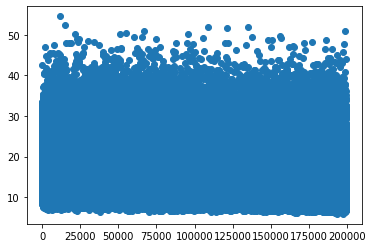

In [14]:
x=np.arange(len(t))
t=list(map(float, t))
plt.scatter(x,t)

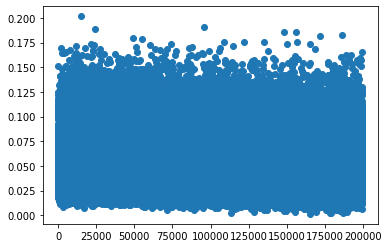

In [15]:
x=np.arange(len(r))
r=list(map(float, r))
plt.scatter(x,r)

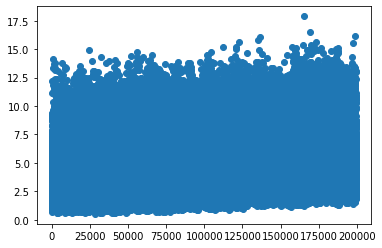

In [16]:
x=np.arange(len(k))
k=list(map(float,k))
plt.scatter(x,k)

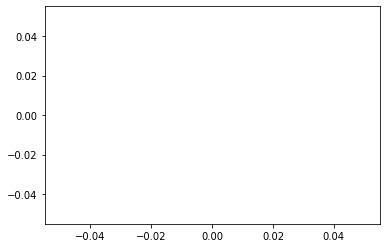

In [20]:
x=np.arange(len(ll))
ll=list(map(float, ll))
plt.scatter(x,ll)

In [62]:
t=[]
r=[]
k=[]
ll=[]

In [63]:
model.train()

for i in range(20000):
    start_time = time.time()
    optimizer.zero_grad()
    train_dataset2=train_dataset2.to(DEVICE)

    tl,rl,kl=compute_loss2(model,train_dataset2.float())

    t.append(tl)
    r.append(rl)
    k.append(kl)

    tl.backward()
    optimizer.step()
    print('Time for epoch {} is {} sec, Loss: {},{},{} '.format(i + 1, time.time()-start_time,tl,rl,kl))
    if (i%100):
        if lambd>lambd_min:
            lambd=lambd*np.exp(-lambd_learning_rate*i)
            
    ll.append(lambd)

Time for epoch 1 is 0.013849020004272461 sec, Loss: 7.582466125488281,0.0014972328208386898,7.208158016204834 
Time for epoch 2 is 0.007296562194824219 sec, Loss: 7.681416034698486,0.001893787644803524,7.2079691886901855 
Time for epoch 3 is 0.006918907165527344 sec, Loss: 7.616672992706299,0.0016353586688637733,7.207833290100098 
Time for epoch 4 is 0.006812095642089844 sec, Loss: 7.622997283935547,0.0016597593203186989,7.208057403564453 
Time for epoch 5 is 0.007321596145629883 sec, Loss: 7.5842437744140625,0.001505630323663354,7.207836151123047 
Time for epoch 6 is 0.007315635681152344 sec, Loss: 7.594766139984131,0.001548082334920764,7.207745552062988 
Time for epoch 7 is 0.007044553756713867 sec, Loss: 7.604266166687012,0.0015841363929212093,7.2082319259643555 
Time for epoch 8 is 0.006932258605957031 sec, Loss: 7.602493762969971,0.001578290481120348,7.207921028137207 
Time for epoch 9 is 0.006914854049682617 sec, Loss: 7.6052117347717285,0.0015889608766883612,7.207971572875977 
T

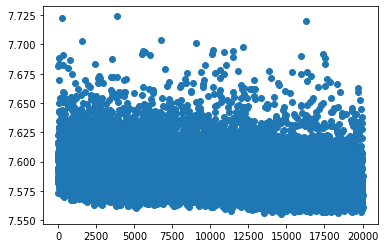

In [64]:
x=np.arange(len(t))
t=list(map(float, t))
plt.scatter(x,t)

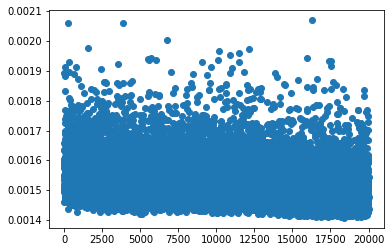

In [65]:
x=np.arange(len(r))
r=list(map(float, r))
plt.scatter(x,r)

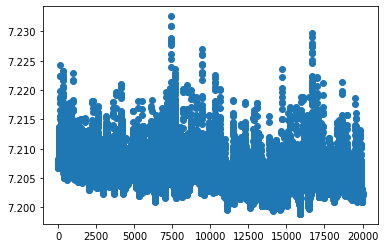

In [66]:
x=np.arange(len(k))
k=list(map(float, k))
plt.scatter(x,k)

In [67]:
model.eval()

bVAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=256, out_features=500, bias=True)
    (5): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=500, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

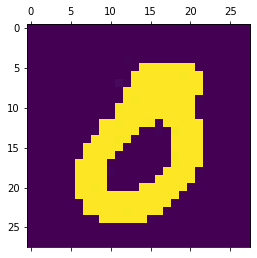

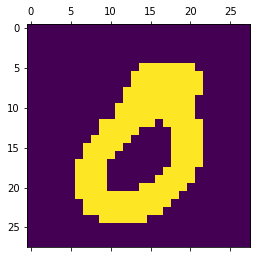

In [76]:
x=train_dataset2[np.random.randint(0,100)]
y=model(x.float().to(DEVICE))[0]
y=y.cpu().detach().numpy()
y=np.reshape(y,(28,28))
plt.matshow(y)

x1=x
x1=x1.cpu().detach().numpy()
plt.matshow(x1.reshape((28,28)))

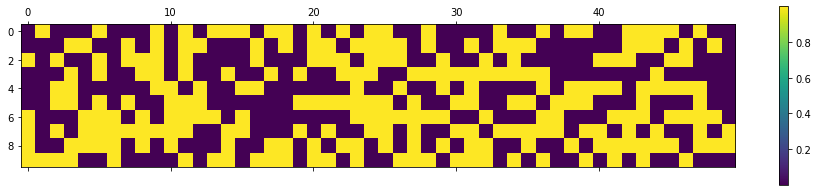

In [69]:
b=model(x.float().to(DEVICE))[1]
b=b.cpu().detach().numpy()
b=np.reshape(b,(10,50))
plt.matshow(b)
plt.colorbar()

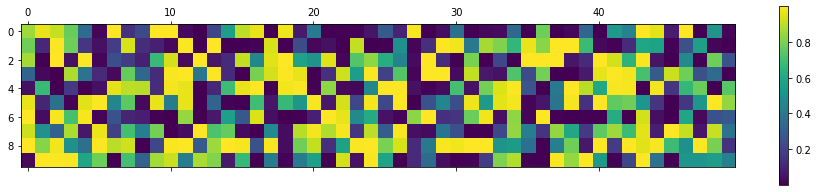

In [70]:
g=model(x.float().to(DEVICE))[2]
g=g.cpu().detach().numpy()
g=np.reshape(g,(10,50))
plt.matshow(g)
plt.colorbar()

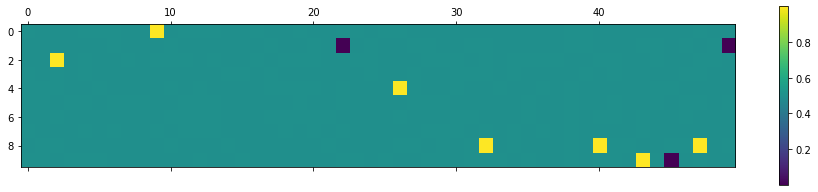

In [71]:
a=model(x.float().to(DEVICE))[3]
a=a.cpu().detach().numpy()
a=np.reshape(a,(10,50))
plt.matshow(a)
plt.colorbar()

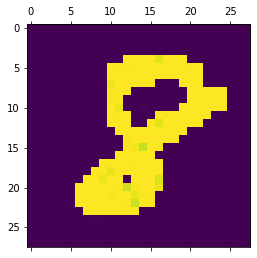

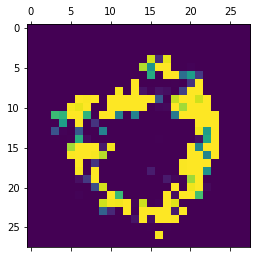

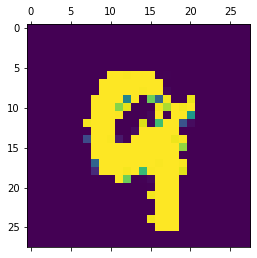

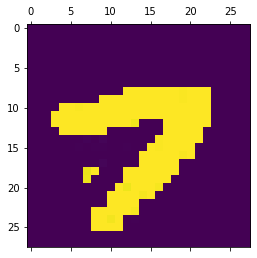

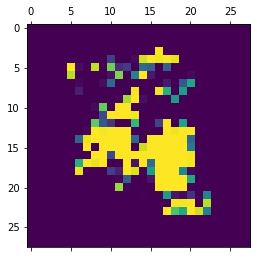

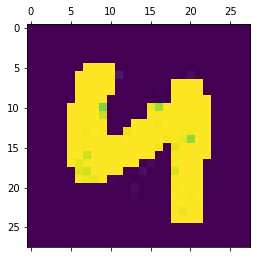

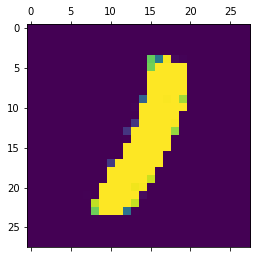

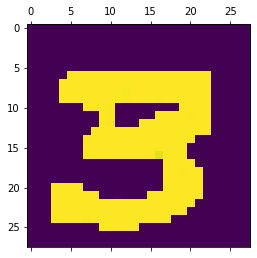

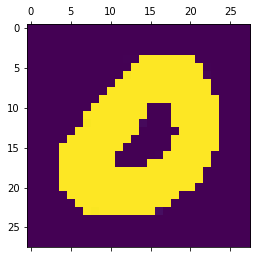

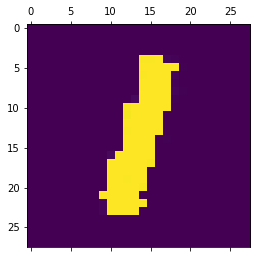

In [79]:
for i in range(10):
    a_check=torch.rand((latent_dim,))
    decoder_input=torch.bernoulli(a_check) .to(DEVICE)
    output=model.decode(decoder_input)
    
    output=output.cpu().detach().numpy()
    output=np.reshape(output,(28,28))
    plt.matshow(output)

In [ ]:
model(x.float().to(DEVICE))

In [60]:
torch.save(model.state_dict(),'bVAE_state_dict3_4_with_batch3')

In [61]:
torch.save(model, 'model3_4_with_batch3')